In [2]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Step 1: Load Data from SQLite
db_path = './FlaskSQLBackend/laptop_data_database.sqlite'
conn = sqlite3.connect(db_path)
query = "SELECT * FROM Laptops"  
df = pd.read_sql(query, conn)
conn.close()

In [6]:
# Step 2: Data Preprocessing
# Handle missing values
df.dropna(inplace=True)


In [8]:
print(df.head())
print(df.info())


   LAPTOP_INDEX COMPANY   TYPENAME  INCHES  MEMORY  \
0             0   Apple  Ultrabook    13.3       8   
1             1   Apple  Ultrabook    13.3       8   
2             2      HP   Notebook    15.6       8   
3             3   Apple  Ultrabook    15.4      16   
4             4   Apple  Ultrabook    13.3       8   

                            GPU OPERATINGSYSTEM  WEIGHT        PRICE  \
0  Intel Iris Plus Graphics 640           macOS    1.37   71378.6832   
1        Intel HD Graphics 6000           macOS    1.34   47895.5232   
2         Intel HD Graphics 620           No OS    1.86   30636.0000   
3            AMD Radeon Pro 455           macOS    1.83  135195.3360   
4  Intel Iris Plus Graphics 650           macOS    1.37   96095.8080   

   SCREENWIDTH  SCREENHEIGHT CPUMANUFACTURER  CPUSPEED CPUMODEL  \
0         2560          1600           Intel       2.3  Core i5   
1         1440           900           Intel       1.8  Core i5   
2         1920          1080           In

In [37]:
# Separate features and target
X = df.drop(columns=['PRICE']) 
y = df['PRICE']


In [12]:
# Encode categorical features if any
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

In [14]:
# Normalize and standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [18]:
# Step 3: Train the Model
if y.nunique() > 10:  # Assuming regression if target has more than 10 unique values
    model = RandomForestRegressor(n_estimators=100, random_state=42)
else:
    model = RandomForestClassifier(n_estimators=100, random_state=42)

In [20]:
# **Fit the model before predicting**
model.fit(X_train, y_train)  

RandomForestRegressor(random_state=42)

In [22]:
# Evaluate model
if isinstance(model, RandomForestRegressor):
    y_pred = model.predict(X_test)
    initial_score = r2_score(y_test, y_pred)
else:
    y_pred = model.predict(X_test)
    initial_score = accuracy_score(y_test, y_pred)

print(f'Initial Model Performance: {initial_score:.2f}')


Initial Model Performance: 0.82


In [24]:
# Step 4: Hyperparameter Optimization
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2' if isinstance(model, RandomForestRegressor) else 'accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)


In [25]:
# Step 5: Final Evaluation
if isinstance(best_model, RandomForestRegressor):
    final_score = r2_score(y_test, y_pred_best)
else:
    final_score = accuracy_score(y_test, y_pred_best)


In [26]:
print(f'Optimized Model Performance: {final_score:.2f}')

Optimized Model Performance: 0.82


In [27]:

print(f"Final Model R-squared: {r2_score(y_test, y_pred):.2f}")


Final Model R-squared: 0.82


In [28]:
# Save performance logs
log_data = pd.DataFrame({'Initial_Score': [initial_score], 'Optimized_Score': [final_score]})
log_data.to_csv('Resources/model_performance_log.csv', index=False)

In [31]:
plt.style.use("ggplot")

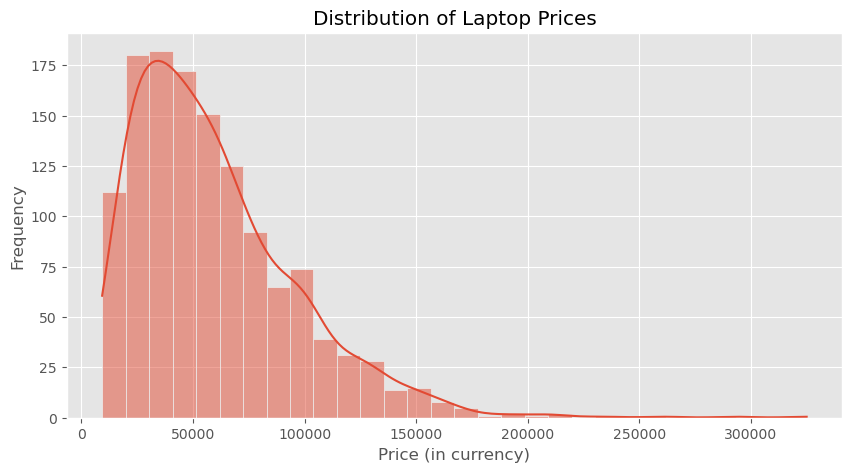

In [39]:
# 1. Price Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["PRICE"], bins=30, kde=True)
plt.xlabel("Price (in currency)")
plt.ylabel("Frequency")
plt.title("Distribution of Laptop Prices")
plt.show()

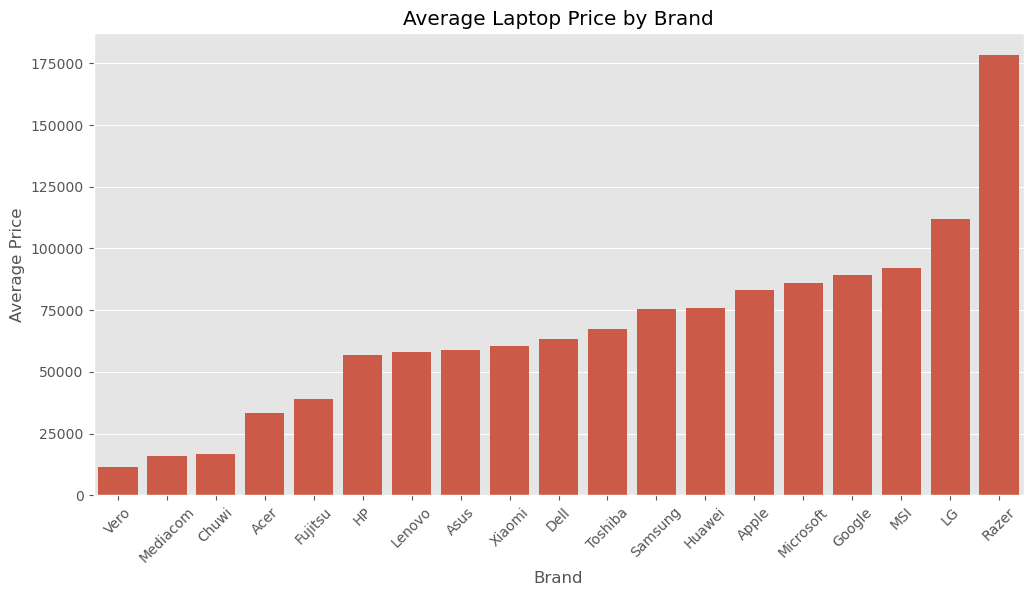

In [43]:
# 2. Brand vs. Average Price
plt.figure(figsize=(12, 6))
brand_avg_price = df.groupby("COMPANY")["PRICE"].mean().sort_values()
sns.barplot(x=brand_avg_price.index, y=brand_avg_price.values)
plt.xticks(rotation=45)
plt.xlabel("Brand")
plt.ylabel("Average Price")
plt.title("Average Laptop Price by Brand")
plt.show()

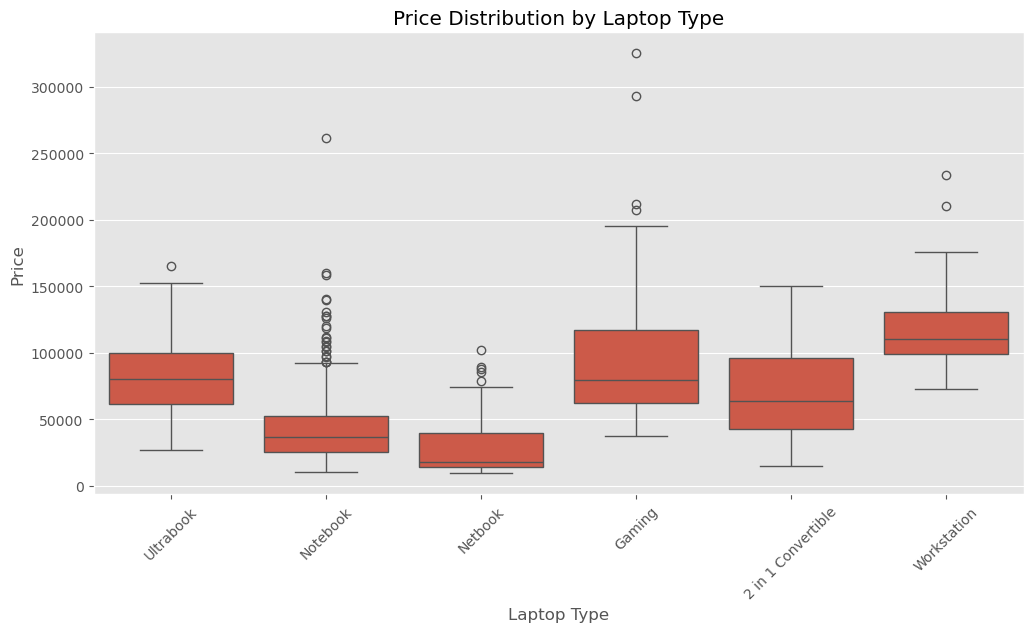

In [47]:
# 3. Laptop Type vs. Price (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x="TYPENAME", y="PRICE", data=df)
plt.xticks(rotation=45)
plt.xlabel("Laptop Type")
plt.ylabel("Price")
plt.title("Price Distribution by Laptop Type")
plt.show()

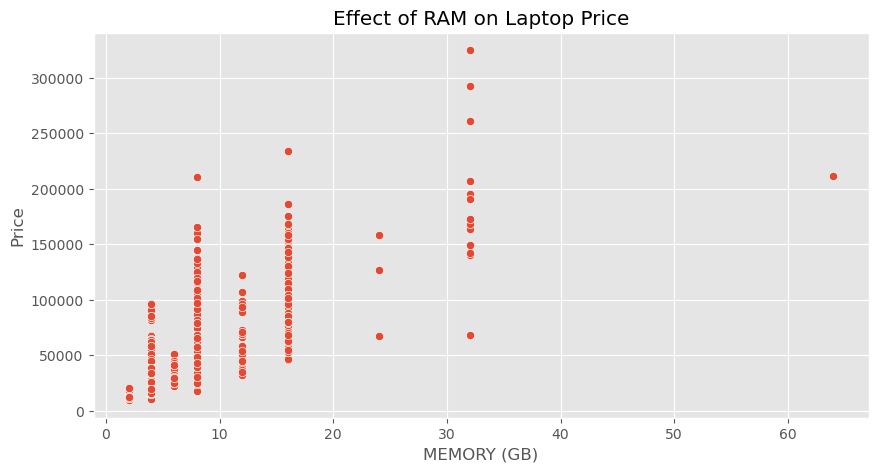

In [61]:
# 4. RAM vs. Price (Scatter plot)
df["MEMORY"] = df["MEMORY"].astype(int)  # Convert RAM to numeric
plt.figure(figsize=(10, 5))
sns.scatterplot(x="MEMORY", y="PRICE", data=df)  # Use correct column names
plt.xlabel("MEMORY (GB)")
plt.ylabel("Price")
plt.title("Effect of RAM on Laptop Price")
plt.show()

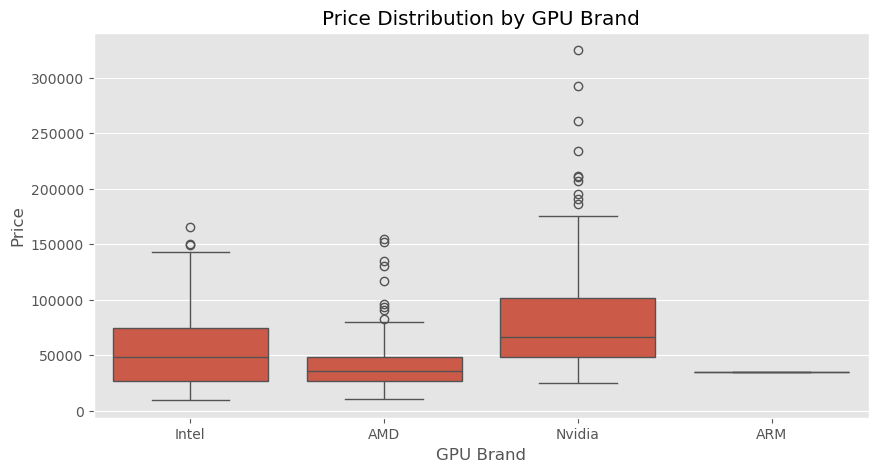

In [73]:
df["GPU_Brand"] = df["GPU"].apply(lambda x: x.split()[0])  # Extracts first word (brand)
plt.figure(figsize=(10, 5))
sns.boxplot(x="GPU_Brand", y="PRICE", data=df)
plt.xlabel("GPU Brand")
plt.ylabel("Price")
plt.title("Price Distribution by GPU Brand")
plt.show()



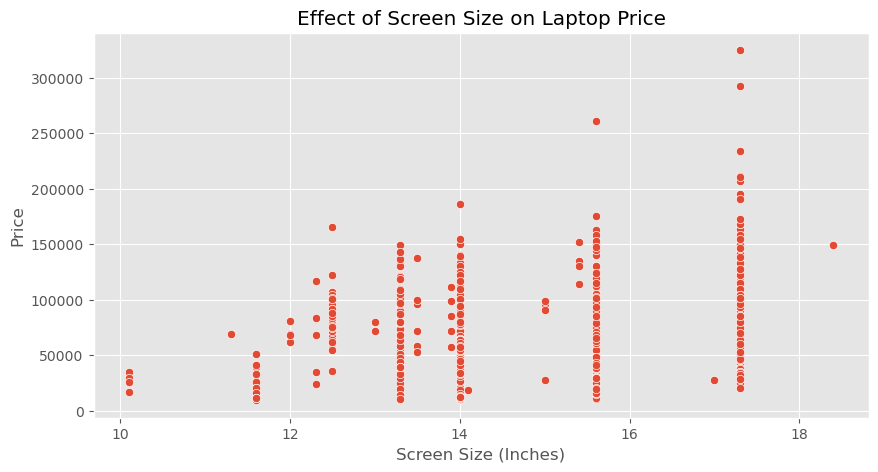

In [65]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x="INCHES", y="PRICE", data=df)
plt.xlabel("Screen Size (Inches)")
plt.ylabel("Price")
plt.title("Effect of Screen Size on Laptop Price")
plt.show()
